In [260]:
import numpy as np
from math import pi
from gdshelpers.geometry.chip import Cell
from gdshelpers.parts.waveguide import Waveguide
from gdshelpers.parts.coupler import GratingCoupler
from gdshelpers.parts.resonator import RingResonator
from gdshelpers.layout import GridLayout
from gdshelpers.parts.marker import CrossMarker
from gdshelpers.parts.marker import SquareMarker
from gdshelpers.helpers.positive_resist import convert_to_positive_resist
from gdshelpers.parts.port import Port
from shapely.geometry import Polygon
from shapely.affinity import scale
from shapely.affinity import translate
from gdshelpers.geometry import geometric_union
from gdshelpers.helpers.under_etching import create_holes_for_under_etching
from gdshelpers.geometry.ebl_frame_generators import raith_marker_frame
from gdshelpers.parts.text import Text
import CM_basic_code
import gdshelpers.geometry
    

In [386]:
def make_single_idt(cell:Cell, pos=[0,0], zno=False, orientation='right', aperture=15, pair_num=50, pitch=1.6, bias=0.005, round_buffer=1, pair=False, pair_distance=0, displacement=0):

    '''fingers'''
    finger_offset = 0.75
    top_fingers = None
    bottom_fingers = None

    finger_width = pitch/4
    finger_len = aperture
    finger_center_x = pos[0]- finger_width/2
    finger_center_y = pos[1] 

    top_fingers = None
    bottom_fingers = None

    for i in range(pair_num * 2):
        finger = CM_basic_code.rectangular_xywh(center_x=finger_center_x, center_y=finger_center_y, length=finger_width, width=aperture)
        if i%2 == 0:
            if top_fingers is None:
                top_fingers = finger
            else:
                top_fingers = geometric_union([top_fingers, finger])
        else:
            if bottom_fingers is None:
                bottom_fingers = finger
            else:
                bottom_fingers = geometric_union([bottom_fingers, finger])
        finger_center_x = finger_center_x - pitch/2

    top_fingers = translate(top_fingers, yoff=finger_offset)
    bottom_fingers = translate(bottom_fingers, yoff=-finger_offset)

    '''arms'''
    top_arm_origin = [pos[0], pos[1] + aperture/2]
    bottom_arm_origin = [pos[0], pos[1] - aperture/2]
    arm_len = pitch * pair_num + pitch/2
    arm_width = 3
    top_arm_center_x = pos[0] - arm_len/2 +pitch/4
    top_arm_center_y = pos[1] + aperture/2 + arm_width/2
    top_arm = CM_basic_code.rectangular_xywh(center_x=top_arm_center_x, center_y=top_arm_center_y, length=arm_len, width=arm_width)

    bottom_arm_center_x = pos[0] - arm_len/2  + pitch/4
    bottom_arm_center_y = pos[1] - aperture/2 - arm_width/2
    bottom_arm = CM_basic_code.rectangular_xywh(center_x=bottom_arm_center_x, center_y=bottom_arm_center_y, length=arm_len, width=arm_width)

    idt = geometric_union([top_arm, bottom_arm, top_fingers, bottom_fingers])

    '''pads'''
    pad_gap = 10
    len_tot = 450

    pad3_len = 250
    pad3_center_x = pos[0] - arm_len - pad3_len/2 - 30
    pad3_center_y = pos[1] + aperture/2 - 30 - pad_gap/2

    pad3_width = 60 - pad_gap
    pad3 = CM_basic_code.rectangular_xywh(center_x=pad3_center_x, center_y=pad3_center_y, length=pad3_len, width=60 - pad_gap)

    pad4_width = 60 + pad_gap
    pad4_len = 40
    pad4_center_x = pad3_center_x - pad3_len/2 - pad_gap - pad4_len/2
    pad4_center_y = pos[1] + aperture/2 - 30 - pad_gap/2
    pad4 = CM_basic_code.rectangular_xywh(center_x=pad4_center_x, center_y=pad4_center_y, length=pad4_len, width=60 + pad_gap)

    pad2_center_x = ((pad3_center_x + pad3_len/2) + (pos[0] + 2)) / 2
    pad2_center_y = pos[1] - aperture/2 - 60
    pad2_len = (pos[0] + 2) - (pad3_center_x + pad3_len/2)
    pad2_width = 120
    pad2 = CM_basic_code.rectangular_xywh(center_x=pad2_center_x, center_y=pad2_center_y, length=pad2_len, width=120)

    pad1_center_x = (pos[0] + 2 + (pad4_center_x - pad4_len/2)) / 2
    pad1_len = pos[0] + 2 - (pad4_center_x - pad4_len/2)
    pad1_center_y= pos[1] + aperture/2 + 60
    pad1 = CM_basic_code.rectangular_xywh(center_x=pad1_center_x, center_y=pad1_center_y, length=pad1_len, width=120)


    
    pad5_center_x = (pad1_center_x - pad1_len/2  + (pad2_center_x - pad2_len/2 - pad_gap)) / 2
    pad5_len = ((pad2_center_x - pad2_len/2 - pad_gap) - (pad1_center_x - pad1_len/2))
    print(pos[1] - 120)
    pad5_center_y = (pad3_center_y - pad3_width/2 - pad_gap + (pos[1] - aperture/2 - 120)) / 2
    print(pad3_center_y)
    print(pad5_center_y)
    pad5_width = pad3_center_y - pad3_width/2 - pad_gap - (pad2_center_y - pad2_width/2)
    pad5 = CM_basic_code.rectangular_xywh(center_x=pad5_center_x, center_y=pad5_center_y, length=pad5_len, width=pad5_width)

    pads = geometric_union([pad1, pad2, pad3, pad4, pad5])

    cell.add_to_layer(3, idt)
    cell.add_to_layer(4, pads)

    if pair is True:
        mirror_center_x = pos[0] + pair_distance/2
        pads_mirror = scale(pads, xfact=-1.0, origin=(mirror_center_x, 0))
        idt_mirror = scale(idt, xfact=-1.0, origin=(mirror_center_x, 0))
        pads_mirror = translate(pads_mirror, yoff=displacement)
        idt_mirror = translate(idt_mirror, yoff=displacement)
        # pads_mirror = translate(pads_mirror, xoff=300)
        cell.add_to_layer(3, idt_mirror)
        cell.add_to_layer(4, pads_mirror)

    return cell

-120
-27.5
-95.0


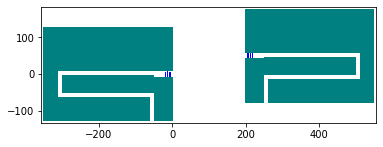

In [387]:
cell = Cell('IDT')
cell = make_single_idt(cell, pos=[0, 0], pair=True, pair_distance=200, displacement=50, aperture=15, pitch=0.4)
cell.show()

In [388]:
cell.save('new_idt.gds')